In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import conda_installer
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import matplotlib.pyplot as plt

2025-04-29 11:40:06.042950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 11:40:06.115452: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normaliz

In [2]:
PDBs = pickle.load(open('Datasets/PDBs_TDS_NMA.pkl', 'rb'))
df = pd.read_csv('Datasets/NMAEntropy_65.csv')

In [3]:
len(PDBs)

65

In [4]:
len(df)

65

In [5]:
df.tail()

,Unnamed: 0,complex_name,TS_comp,TS_host,TS_ligand,DELTA_S
60,61,cb7-18,108.6247,94.1358,28.8836,-13.4130
61,62,cb7-20,110.0839,94.1358,29.3665,-12.2029
62,63,cb7-22,108.6411,94.1358,31.1067,-13.4184
63,64,cb7-23,105.1555,94.1358,25.6966,-19.5447
64,65,cb7-24,110.1865,94.1358,31.4818,-16.7849


In [6]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['complex_name'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])

In [7]:
from models.dcFeaturizer import atom_features as get_atom_features
def featurize(molecule, info):
    
    atom_features = []
    for atom in molecule.GetAtoms():
        new_feature = get_atom_features(atom).tolist()
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        new_feature += [atom.GetMass(), atom.GetAtomicNum(),atom.GetFormalCharge()]
        new_feature += [position.x, position.y, position.z]
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]
        atom_features.append(np.concatenate([new_feature, info], 0))
    # print(len(atom_features[0]))
    return np.array(atom_features)

In [8]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['complex_name'] == pdb]['DELTA_S'].to_numpy()[0])

In [9]:
X[0].shape, y[0]

((71, 41), -1.2985)

In [10]:
len(y)

65

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(52, 13, 52, 13)

In [13]:
# y_train[0],X_train[0],info[0]

In [14]:
# Import custom layers
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping


class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2')
        self.dense6 = tf.keras.layers.Dense(1, name='dense6')
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([-.3, 1, -1, -1]),
                                             bias_initializer=tf.keras.initializers.Zeros())
        self.all_layer_1_weights = []

    def addRule(self, rule, start_index, end_index=None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)

    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs):
        physics_info = inputs[:, 0, 38:]
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dense5(x)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred[0] - y_true))) + K.abs(1 / K.mean(.2 + y_pred[1]))


def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

m = PGGCNModel()
m.addRule("sum", 0, 32)
m.addRule("multiply", 32, 33)
m.addRule("distance", 33, 36)
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
m.compile(loss=pure_rmse, optimizer=opt)
input_shapes = []
for i in range(len(X_train)):
    input_shapes.append(np.array(X_train[i]).shape[0])
m.set_input_shapes(input_shapes)
for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_train[i].shape[0], 41])
        X_train[i] = np.concatenate([X_train[i], new_list], 0)
X_train = np.array(X_train)
y_train = np.array(y_train)
early_stop = EarlyStopping(
    monitor='loss',           
    patience=20,              
    restore_best_weights=True, 
    min_delta=0.001,          
    verbose=1                 
)
hist = m.fit(X_train, y_train, epochs = 600, batch_size=len(X_train), callbacks=[early_stop])

Epoch 1/600


2025-04-29 11:40:22.712800: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-29 11:40:22.712835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (curie.cluster): /proc/driver/nvidia/version does not exist
2025-04-29 11:40:22.713281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1/1 [==============================] - 48s 48s/step - loss: 1.3839
Epoch 2/600
1/1 [==============================] - 1s 666ms/step - loss: 1.8836
Epoch 3/600
1/1 [==============================] - 0s 451ms/step - loss: 1.4287
Epoch 4/600
1/1 [==============================] - 1s 689ms/step - loss: 1.4951
Epoch 5/600
1/1 [==============================] - 1s 676ms/step - loss: 1.6468
Epoch 6/600
1/1 [==============================] - 1s 676ms/step - loss: 1.5399
Epoch 7/600
1/1 [==============================] - 1s 667ms/step - loss: 1.3900
Epoch 8/600
1/1 [==============================] - 1s 632ms/step - loss: 1.4051
Epoch 9/600
1/1 [==============================] - 1s 666ms/step - loss: 1.5033
Epoch 10/600
1/1 [==============================] - 1s 670ms/step - loss: 1.5115
Epoch 11/60

1/1 [==============================] - 1s 619ms/step - loss: 1.3672
Epoch 97/600
1/1 [==============================] - 1s 662ms/step - loss: 1.3670
Epoch 98/600
1/1 [==============================] - 1s 655ms/step - loss: 1.3670
Epoch 99/600
1/1 [==============================] - 1s 643ms/step - loss: 1.3669
Epoch 100/600
1/1 [==============================] - 1s 653ms/step - loss: 1.3667
Epoch 101/600
1/1 [==============================] - 1s 651ms/step - loss: 1.3666
Epoch 102/600
1/1 [==============================] - 1s 674ms/step - loss: 1.3665
Epoch 103/600
1/1 [==============================] - 1s 667ms/step - loss: 1.3664
Epoch 104/600
1/1 [==============================] - 1s 665ms/step - loss: 1.3663
Epoch 105/600
1/1 [==============================] - 1s 663ms/step - loss: 1.3662
Epoch 106/600
1/1 [==============================] - 1s 642ms/step - loss: 1.3661
Epoch 107/600
1/1 [==============================] - 1s 636ms/step - loss: 1.3660
Epoch 108/600
1/1 [==============

1/1 [==============================] - 1s 662ms/step - loss: 1.3458
Epoch 197/600
1/1 [==============================] - 1s 648ms/step - loss: 1.3455
Epoch 198/600
1/1 [==============================] - 1s 631ms/step - loss: 1.3451
Epoch 199/600
1/1 [==============================] - 1s 655ms/step - loss: 1.3448
Epoch 200/600
1/1 [==============================] - 1s 666ms/step - loss: 1.3444
Epoch 201/600
1/1 [==============================] - 1s 658ms/step - loss: 1.3441
Epoch 202/600
1/1 [==============================] - 1s 670ms/step - loss: 1.3437
Epoch 203/600
1/1 [==============================] - 1s 672ms/step - loss: 1.3434
Epoch 204/600
1/1 [==============================] - 1s 634ms/step - loss: 1.3430
Epoch 205/600
1/1 [==============================] - 1s 655ms/step - loss: 1.3427
Epoch 206/600
1/1 [==============================] - 1s 670ms/step - loss: 1.3423
Epoch 207/600
1/1 [==============================] - 1s 653ms/step - loss: 1.3420
Epoch 208/600
1/1 [===========

1/1 [==============================] - 1s 676ms/step - loss: 1.3097
Epoch 297/600
1/1 [==============================] - 1s 673ms/step - loss: 1.3094
Epoch 298/600
1/1 [==============================] - 1s 675ms/step - loss: 1.3091
Epoch 299/600
1/1 [==============================] - 1s 661ms/step - loss: 1.3087
Epoch 300/600
1/1 [==============================] - 1s 642ms/step - loss: 1.3084
Epoch 301/600
1/1 [==============================] - 1s 651ms/step - loss: 1.3081
Epoch 302/600
1/1 [==============================] - 1s 661ms/step - loss: 1.3078
Epoch 303/600
1/1 [==============================] - 1s 660ms/step - loss: 1.3075
Epoch 304/600
1/1 [==============================] - 1s 680ms/step - loss: 1.3072
Epoch 305/600
1/1 [==============================] - 1s 667ms/step - loss: 1.3070
Epoch 306/600
1/1 [==============================] - 1s 668ms/step - loss: 1.3067
Epoch 307/600
1/1 [==============================] - 1s 650ms/step - loss: 1.3064
Epoch 308/600
1/1 [===========

1/1 [==============================] - 1s 673ms/step - loss: 1.2898
Epoch 397/600
1/1 [==============================] - 1s 646ms/step - loss: 1.2897
Epoch 398/600
1/1 [==============================] - 1s 659ms/step - loss: 1.2896
Epoch 399/600
1/1 [==============================] - 1s 654ms/step - loss: 1.2895
Epoch 400/600
1/1 [==============================] - 1s 652ms/step - loss: 1.2894
Epoch 401/600
1/1 [==============================] - 1s 679ms/step - loss: 1.2893
Epoch 402/600
1/1 [==============================] - 1s 665ms/step - loss: 1.2892
Epoch 403/600
1/1 [==============================] - 1s 685ms/step - loss: 1.2891
Epoch 404/600
1/1 [==============================] - 1s 664ms/step - loss: 1.2890
Epoch 405/600
1/1 [==============================] - 1s 676ms/step - loss: 1.2889
Epoch 406/600
1/1 [==============================] - 1s 668ms/step - loss: 1.2889
Epoch 407/600
1/1 [==============================] - 1s 650ms/step - loss: 1.2888
Epoch 408/600
1/1 [===========

In [15]:
# len(X_test)

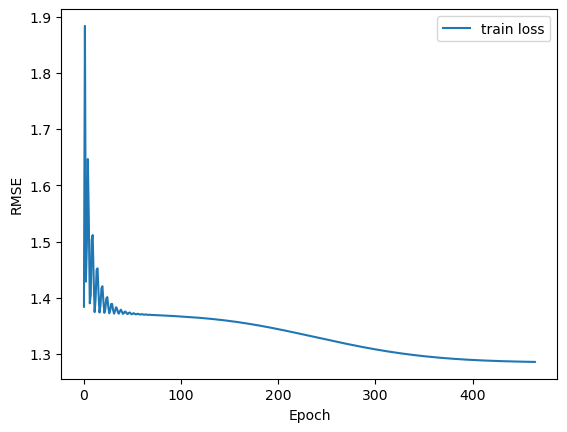

In [16]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(hist.history['loss'], label='train loss')

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [17]:
import copy
input_shapes = []
for i in range(len(X_test)):
    input_shapes.append(np.array(X_test[i]).shape[0])
m.set_input_shapes(input_shapes)

for i in range(len(X_test)):
    if X_test[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test[i].shape[0], 41])
        X_test[i] = np.concatenate([X_test[i], new_list], 0)
X_test = np.array(X_test)
x_c = copy.deepcopy(X_test)
y_test = np.array(y_test)
y_pred_test = m.predict(X_test)
y_pred_test = np.array(y_pred_test)
y_difference = np.mean(np.abs(np.abs(y_test) - np.abs(y_pred_test)))
eval = m.evaluate(X_test, y_test)
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference)))


1/1 [==============================] - 4s 4s/step - loss: 2.1085
The mean absolute difference between y_tru & y_pred is : 5.770160050690386
